# Grad-CAM
An example of implementation with PyTorch

In [1]:
import torch
import timm
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from PIL import Image
from sklearn.preprocessing import LabelEncoder

/rds/general/user/ms7024/home/anaconda3/envs/breakhis/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define the function

def generate_gradcam(model, input_tensor, target_class, target_layer):
    model.eval()

    # 1. Store feature maps and gradients
    activations = []
    gradients = []

    def forward_hook(module, input, output): # capture feature maps of that layer
        activations.append(output.detach())

    def backward_hook(module, grad_input, grad_output): # capture gradients of output score wrt each feature map
        gradients.append(grad_output[0].detach())

    # Register hooks - basically making sure that feature maps and corresponding gradients of our layer of interest are recorded
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(input_tensor) # output
    pred_class = output.argmax(dim=1).item() # extract logit for class=1 (malignant)

    # Backward pass for target class
    model.zero_grad()
    class_score = output[:, target_class]
    class_score.backward() # Compute dy/DA where y it output, A is feature map (matrix)

    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    # Get the stored activations and gradients
    grad = gradients[0]       
    act = activations[0]       
    weights = grad.mean(dim=(2, 3), keepdim=True)  # global average pooling

    # Compute weighted combination
    cam = (weights * act).sum(dim=1, keepdim=True)
    cam = F.relu(cam) # because we only case about positive influences
    cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False) # from pixel to heatmap2
    #  can uncomment the line above if  want to see "Pixelated" values instead of heatmap
    
    # Normalize for visualization
    cam = cam.squeeze().cpu().numpy()
    cam = (cam - cam.min()) / (cam.max() - cam.min())

    return cam, pred_class

In [9]:
# Get data (for binary only)


class BreakHisDataset(Dataset): # Subclass Dataset, which is required for using DataLoader
    def __init__(self, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.le = LabelEncoder()
        self.df['label'] = self.le.fit_transform(self.df['label']) # convert to binary
        self.class_names = list(self.le.classes_)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'filepath']
        label = self.df.loc[idx, 'label']
        imgid = self.df['Unnamed: 0'][idx].item()
        #subtype = self.df.loc[idx, 'label_diagnosis']   
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long), torch.tensor(imgid)


# For original (non-augumented) data
# gradcam = BreakHisDataset(csv_path="../data/metadata.csv", transform=transform)
# gradcam_loader = DataLoader(gradcam, batch_size=32, shuffle=True)

# Single image
gradcam = BreakHisDataset(csv_path="../data/metadata.csv", transform=transform)
gradcam_loader = DataLoader(gradcam, batch_size=32, shuffle=False)

In [6]:
df = pd.read_csv

2485

In [ ]:
# Import saved model
model = timm.create_model('convnextv2_atto.fcmae', pretrained=False, num_classes=2) # model architecture
model.load_state_dict(torch.load("convnext_v2_outputs/Single_Model/best_model_binary.pth")) # saved weights
model.eval()

Image id: 4416


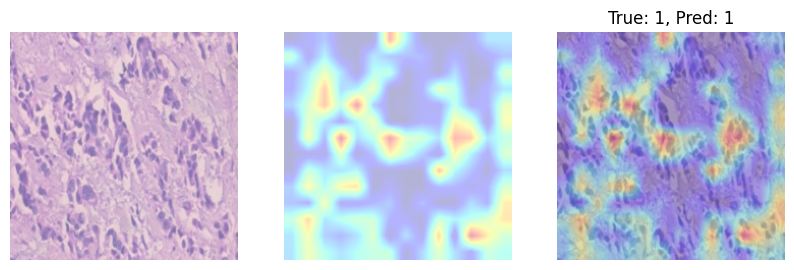

In [181]:
# Apply to images of interest

from PIL import Image

target_layer = list(model.stages[2].children())[-1][1] # choose target layer

# Get a batch from test_loader
#img_iter = iter(gradcam_loader) # comment out after 1st run if want to keep iterating over images
image_batch, label_batch, imgid = next(img_iter)
image = image_batch[0].unsqueeze(0)
label = label_batch[0].item()
imgid = imgid[0].item()
# Run Grad-CAM
cam, pred_class = generate_gradcam(model, image, target_class=0, target_layer=target_layer)
print(f"Image id: {imgid}")
f, ax = plt.subplots(nrows = 1, ncols=3, figsize = (10, 4))
ax[0].imshow(to_pil_image(image.squeeze())) # normal image
ax[1].imshow(cam, cmap='jet', alpha=0.3) # heatmap
ax[2].imshow(to_pil_image(image.squeeze())) # overlaid Grad-CAM
ax[2].imshow(cam, cmap='jet', alpha=0.3)
plt.title(f"True: {label}, Pred: {pred_class}")
for i in range(3):
    ax[i].axis('off')
plt.show()

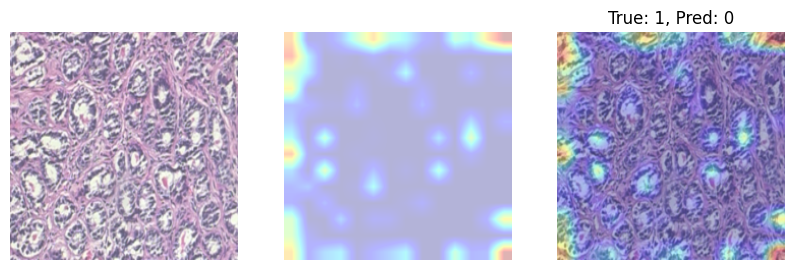

In [174]:
# Apply to images of interest

from PIL import Image

target_layer = list(model.stages[2].children())[-1][1] # choose target layer

# Get a batch from test_loader
# img_iter = iter(gradcam_loader) # comment out after 1st run if want to keep iterating over images
# image_batch, label_batch = next(img_iter)
# image = image_batch[0].unsqueeze(0)
# label = label_batch[0].item()

image = gradcam[0][0].unsqueeze(0)
# Run Grad-CAM
cam, pred_class = generate_gradcam(model, image, target_class=0, target_layer=target_layer)

f, ax = plt.subplots(nrows = 1, ncols=3, figsize = (10, 4))
ax[0].imshow(to_pil_image(image.squeeze())) # normal image
ax[1].imshow(cam, cmap='jet', alpha=0.3) # heatmap
ax[2].imshow(to_pil_image(image.squeeze())) # overlaid Grad-CAM
ax[2].imshow(cam, cmap='jet', alpha=0.3)
plt.title(f"True: {label}, Pred: {pred_class}")
for i in range(3):
    ax[i].axis('off')
plt.show()

In [3]:
import pandas as pd

# Binary
convnext_binary = pd.read_csv("../Final_Results/ConvNeXT-V2/binary_perepoch.csv")
densenet_binary = pd.read_csv("../Final_Results/DenseNet121/binary_1/binary_hpo_history_20epoch_patience5.csv")
resent_binary = pd.read_csv("../Final_Results/ResNet50/binary_perepoch.csv")

# Multi-class 
convnext_multi = pd.read_csv("../Final_Results/ConvNeXT-V2/multiclass_perepoch.csv")
densenet_multi = pd.read_csv("../Final_Results/DenseNet121/multi_0/multi_hpo_history.csv")
resent_multi = pd.read_csv("../Final_Results/ResNet50/multiclass_perepoch.csv")

# convnext cols
convnext_binary['ConvNexT-V2 Train'] = convnext_binary['Train_accuracy']
convnext_binary['ConvNexT-V2 Validation'] = convnext_binary['Test_accuracy']
convnext_multi['ConvNexT-V2 Train'] = convnext_multi['Train_accuracy']
convnext_multi['ConvNexT-V2 Validation'] = convnext_multi['Test_accuracy']

# resnet
resent_binary['ResNet-50 Train'] = resent_binary['train_accuracy']
resent_binary['ResNet-50 Validation'] = resent_binary['test_accuracy']
resent_multi['ResNet-50 Train'] = resent_multi['train_accuracy']
resent_multi['ResNet-50 Validation'] = resent_multi['test_accuracy']

# densenet
densenet_binary['DenseNet-121 Train'] = densenet_binary['Train Accuracy']
densenet_binary['DenseNet-121 Validation'] = densenet_binary['Validation Accuracy']
densenet_multi['DenseNet-121 Train'] = densenet_multi['Train Accuracy']
densenet_multi['DenseNet-121 Validation'] = densenet_multi['Validation Accuracy']

densenet_binary

,Epoch,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,DenseNet-121 Train,DenseNet-121 Validation
0,0,0.909450,0.238645,0.931220,0.214846,0.909450,0.931220
1,1,0.962887,0.103954,0.954147,0.147146,0.962887,0.954147
2,2,0.978694,0.072349,0.929198,0.207688,0.978694,0.929198
3,3,0.988488,0.041640,0.946730,0.198736,0.988488,0.946730
4,4,0.989519,0.032282,0.944032,0.253709,0.989519,0.944032
5,5,0.987285,0.043855,0.925152,0.244954,0.987285,0.925152
6,6,0.991924,0.031280,0.962239,0.123157,0.991924,0.962239
7,7,0.992440,0.027497,0.948753,0.243851,0.992440,0.948753
8,8,0.997251,0.012878,0.860418,0.515959,0.997251,0.860418
9,9,0.995361,0.017722,0.866487,0.706604,0.995361,0.866487


In [4]:
binary = pd.merge(convnext_binary, resent_binary, on = "Unnamed: 0", how='outer')
binary = pd.merge(binary, densenet_binary, left_on = "Unnamed: 0", right_on="Epoch", how='outer')
binary = binary[["ConvNexT-V2 Train", "ConvNexT-V2 Validation", "ResNet-50 Train", "ResNet-50 Validation",
                "DenseNet-121 Train", "DenseNet-121 Validation"]]
binary

,ConvNexT-V2 Train,ConvNexT-V2 Validation,ResNet-50 Train,ResNet-50 Validation,DenseNet-121 Train,DenseNet-121 Validation
0,0.876804,0.900202,0.916667,0.921780,0.909450,0.931220
1,0.935567,0.910317,0.956529,0.950775,0.962887,0.954147
2,0.958076,0.870533,0.974570,0.914363,0.978694,0.929198
3,0.975773,0.896156,0.978351,0.943358,0.988488,0.946730
4,0.983333,0.927175,0.985052,0.936615,0.989519,0.944032
5,0.987285,0.952798,0.980928,0.721510,0.987285,0.925152
6,0.987285,0.955496,0.985911,0.944032,0.991924,0.962239
7,0.991409,0.950775,0.986598,0.942684,0.992440,0.948753
8,0.995704,0.950101,0.990893,0.807822,0.997251,0.860418
9,0.993814,0.950101,0.986598,0.942684,0.995361,0.866487


,ConvNexT-V2 Train,ConvNexT-V2 Validation,ResNet-50 Train,ResNet-50 Validation,DenseNet-121 Train,DenseNet-121 Validation
0,0.876804,0.900202,0.916667,0.921780,0.911512,0.940661
1,0.935567,0.910317,0.956529,0.950775,0.962027,0.933918
2,0.958076,0.870533,0.974570,0.914363,0.981787,0.964936
3,0.975773,0.896156,0.978351,0.943358,0.986082,0.946730
4,0.983333,0.927175,0.985052,0.936615,0.989347,0.959541
5,0.987285,0.952798,0.980928,0.721510,0.989519,0.964936
6,0.987285,0.955496,0.985911,0.944032,0.993814,0.836143
7,0.991409,0.950775,0.986598,0.942684,0.992612,0.921106
8,0.995704,0.950101,0.990893,0.807822,NaN,NaN
9,0.993814,0.950101,0.986598,0.942684,NaN,NaN


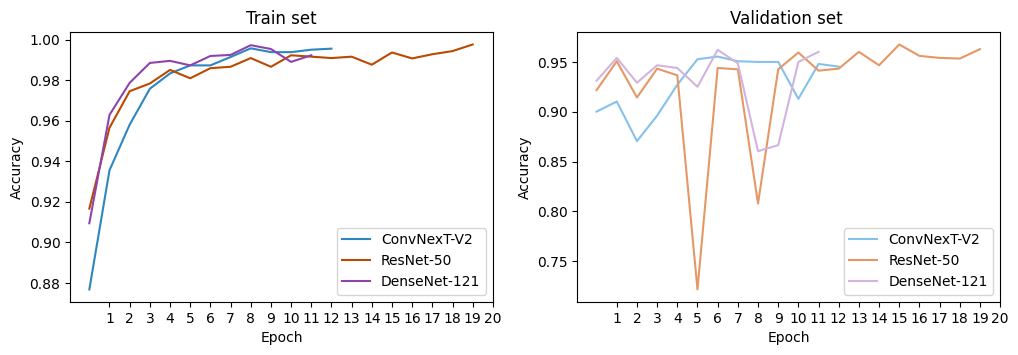

In [5]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(nrows = 1, ncols=2, figsize = (12, 3.5))
colors = ["#2E86C1", "#85C1E9", "#BA4A00", "#E59866", "#8E44AD", "#D2B4DE"]
for i, col in enumerate(binary.columns):
        if i == 0:
            ax[0].plot(range(binary.shape[0]), binary.loc[:, col], label = col.split(" ", 1)[0], color=colors[i])
        elif i % 2 == 0:
            ax[0].plot(range(binary.shape[0]), binary.loc[:, col], label = col.split(" ", 1)[0], color=colors[i])
        else:
            ax[1].plot(range(binary.shape[0]), binary.loc[:, col], label = col.split(" ", 1)[0], color=colors[i])

ax[0].legend(prop={'size': 10}, loc='lower right')
ax[1].legend(prop={'size': 10}, loc='lower right')
ax[0].set_title("Train set")
ax[1].set_title("Validation set ")
for i in [0,1]:
    ax[i].set_xticks([i+1 for i in range(binary.shape[0])])
    ax[i].set_ylabel("Accuracy")
    ax[i].set_xlabel("Epoch")
plt.show()

In [5]:
multi = pd.merge(convnext_multi, resent_multi, on = "Unnamed: 0", how='outer')
multi = pd.merge(multi, densenet_multi, left_on = "Unnamed: 0", right_on="Epoch", how='outer')
multi = multi[["ConvNexT-V2 Train", "ConvNexT-V2 Validation", "ResNet-50 Train", "ResNet-50 Validation",
                "DenseNet-121 Train", "DenseNet-121 Validation"]]
multi

,ConvNexT-V2 Train,ConvNexT-V2 Validation,ResNet-50 Train,ResNet-50 Validation,DenseNet-121 Train,DenseNet-121 Validation
0,0.517869,0.602158,0.469244,0.554956,0.573883,0.712744
1,0.670275,0.709373,0.711168,0.656777,0.772509,0.763318
2,0.751546,0.687121,0.827491,0.712070,0.861168,0.796359
3,0.815808,0.738368,0.902577,0.731625,0.914089,0.807148
4,0.841753,0.753877,0.945704,0.757249,0.933333,0.739042
5,0.888144,0.832097,0.965808,0.767363,0.950172,0.809845
6,0.908591,0.847606,0.979725,0.775455,0.953780,0.817937
7,0.938144,0.852326,0.985567,0.780175,0.958763,0.776129
8,0.943471,0.833446,0.988832,0.788941,0.954983,0.801753
9,0.945533,0.846932,0.989175,0.791639,0.966495,0.824680


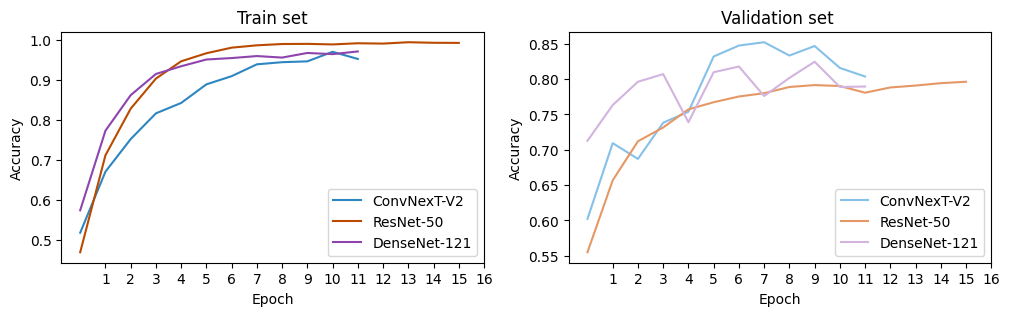

In [6]:
f, ax = plt.subplots(nrows = 1, ncols=2, figsize = (12, 3))
colors = ["#2E86C1", "#85C1E9", "#BA4A00", "#E59866", "#8E44AD", "#D2B4DE"]
for i, col in enumerate(multi.columns):
        if i == 0:
            ax[0].plot(range(multi.shape[0]), multi.loc[:, col], label = col.split(" ", 1)[0], color=colors[i])
        elif i % 2 == 0:
            ax[0].plot(range(multi.shape[0]), multi.loc[:, col], label = col.split(" ", 1)[0], color=colors[i])
        else:
            ax[1].plot(range(multi.shape[0]), multi.loc[:, col], label = col.split(" ", 1)[0], color=colors[i])

ax[0].legend(prop={'size': 10}, loc='lower right')
ax[1].legend(prop={'size': 10}, loc='lower right')
ax[0].set_title("Train set")
ax[1].set_title("Validation set ")
for i in [0,1]:
    ax[i].set_xticks([i+1 for i in range(multi.shape[0])])
    ax[i].set_ylabel("Accuracy")
    ax[i].set_xlabel("Epoch")
plt.show()

In [7]:
import pandas as pd
conv_test = pd.read_csv("../Final_Results/ConvNeXT-V2/multiclass_holdout.csv")
dens_test = pd.read_csv("../Final_Results/DenseNet121/multi_0/multi_0_full_metrics_summary.csv")
resn_test = pd.read_csv("../Final_Results/ResNet50/multiclass_model_metrics.csv")

In [20]:
conv_test =conv_test.rename(columns={"Holdout_Recall":"convnext2 recall", "Holdout_F1":"convnext2 F1", "Holdout_AUC": "convnext2 AUC"})
dens_test=dens_test.rename(columns={"recall":"densenet recall", "f1-score":"densenet f1", "AUC": "densenet AUC"})
resn_test = resn_test.rename(columns={"recall":"resnet recall", "f1-score":"resnet f1", "AUC": "resnet AUC"})



,Unnamed: 0,precision,resnet recall,resnet f1,support,resnet AUC,FPR,FNR
0,adenosis,0.827273,0.834862,0.831050,109.0,0.992789,0.010166,0.165138
1,ductal_carcinoma,0.799389,0.933413,0.861218,841.0,0.948500,0.173263,0.066587
2,fibroadenoma,0.742038,0.847273,0.791171,275.0,0.975246,0.047563,0.152727
3,lobular_carcinoma,0.743590,0.527273,0.617021,165.0,0.964303,0.016547,0.472727
4,mucinous_carcinoma,0.659459,0.713450,0.685393,171.0,0.942676,0.034864,0.286550
5,papillary_carcinoma,0.910714,0.337748,0.492754,151.0,0.947277,0.002737,0.662252
6,phyllodes_tumor,0.779412,0.530000,0.630952,100.0,0.968147,0.007987,0.470000
7,tubular_adenoma,0.917808,0.807229,0.858974,166.0,0.993095,0.006623,0.192771
8,accuracy,0.786653,NaN,NaN,NaN,NaN,NaN,NaN
9,macro avg,0.797460,0.691406,0.721067,1978.0,NaN,NaN,NaN


In [37]:
resn_test

,Unnamed: 0,precision,resnet recall,resnet f1,support,resnet AUC,FPR,FNR
0,adenosis,0.827273,0.834862,0.831050,109.0,0.992789,0.010166,0.165138
1,ductal_carcinoma,0.799389,0.933413,0.861218,841.0,0.948500,0.173263,0.066587
2,fibroadenoma,0.742038,0.847273,0.791171,275.0,0.975246,0.047563,0.152727
3,lobular_carcinoma,0.743590,0.527273,0.617021,165.0,0.964303,0.016547,0.472727
4,mucinous_carcinoma,0.659459,0.713450,0.685393,171.0,0.942676,0.034864,0.286550
5,papillary_carcinoma,0.910714,0.337748,0.492754,151.0,0.947277,0.002737,0.662252
6,phyllodes_tumor,0.779412,0.530000,0.630952,100.0,0.968147,0.007987,0.470000
7,tubular_adenoma,0.917808,0.807229,0.858974,166.0,0.993095,0.006623,0.192771
8,accuracy,0.786653,NaN,NaN,NaN,NaN,NaN,NaN
9,macro avg,0.797460,0.691406,0.721067,1978.0,NaN,NaN,NaN


In [33]:
holdout_m = resn_test.merge(dens_test, on="Unnamed: 0")
holdout_m = holdout_m.merge(conv_test, how="right", left_on="Unnamed: 0", right_on="Class")
holdout_m = holdout_m[['Class', 'resnet recall', 'resnet f1','resnet AUC','densenet recall',
                       'densenet f1','densenet AUC','convnext2 recall','convnext2 F1','convnext2 AUC']]
holdout_m.to_csv("combined_holdout_metrics.csv")

In [34]:
holdout_m

,Class,resnet recall,resnet f1,resnet AUC,densenet recall,densenet f1,densenet AUC,convnext2 recall,convnext2 F1,convnext2 AUC
0,adenosis,0.834862,0.831050,0.992789,0.981651,0.823077,0.998115,0.587156,0.731429,0.993702
1,ductal_carcinoma,0.933413,0.861218,0.948500,0.860880,0.866029,0.959172,0.976219,0.873404,0.966983
2,fibroadenoma,0.847273,0.791171,0.975246,0.800000,0.825516,0.977215,0.912727,0.800638,0.976666
3,lobular_carcinoma,0.527273,0.617021,0.964303,0.830303,0.658654,0.963366,0.630303,0.660317,0.972388
4,mucinous_carcinoma,0.713450,0.685393,0.942676,0.766082,0.834395,0.982285,0.567251,0.700361,0.944741
5,papillary_carcinoma,0.337748,0.492754,0.947277,0.543046,0.672131,0.969885,0.456954,0.610619,0.964517
6,phyllodes_tumor,0.530000,0.630952,0.968147,0.800000,0.808081,0.987045,0.370000,0.506849,0.959084
7,tubular_adenoma,0.807229,0.858974,0.993095,0.843373,0.877743,0.994358,0.807229,0.864516,0.993368


In [35]:
df = holdout_m

df.columns = pd.MultiIndex.from_tuples(
    [tuple(col.split(' ', 1)) for col in df.columns],
    names=['Model', 'Metric']
)

# Style the table with three decimal places and a global color gradient
styled = (
    df.style
      .format("{:.3f}")
      .background_gradient(axis=None)
      .set_caption("Model Performance by Class")
)

# In a Jupyter notebook, just display:
styled

# To export to an HTML file:
html = styled.render()
with open("performance_table.html", "w") as f:
    f.write(html)

AttributeError: 'Styler' object has no attribute 'render'